# Full flux modeling of LBTI observations

## Workflow

- Subtract PSF-convolved disk model from data
- Use photutils.psf to model out the point sources
- Determine the RMS of the residual
- Iterate to minimize that RMS

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import paths
from photutils.psf import (BasicPSFPhotometry, IterativelySubtractedPSFPhotometry, DAOGroup, FittableImageModel)
from photutils.detection import StarFinder
from photutils.background import BiweightLocationBackground
from astropy.io import fits
from astropy.table import Table, vstack
from scipy.interpolate import RegularGridInterpolator
from astropy.modeling.fitting import (TRFLSQFitter, LMLSQFitter, DogBoxLSQFitter, SimplexLSQFitter, SLSQPLSQFitter)
from astropy.modeling.functional_models import Disk2D
from astroquery.jplhorizons import Horizons
from datetime import datetime, timedelta
import astropy.units as u
import copy
from astropy.convolution import convolve_models
from shift_stack_moons.shift_stack_moons import chisq_stack

## Load the PSF and data

<class 'photutils.psf.models.EPSFModel'>
Name: EPSFModel (FittableImageModel)
N_inputs: 2
N_outputs: 1
Fittable parameters: ('flux', 'x_0', 'y_0')
7


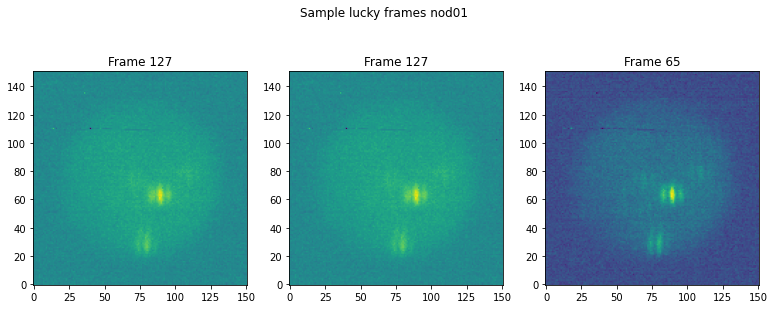

7


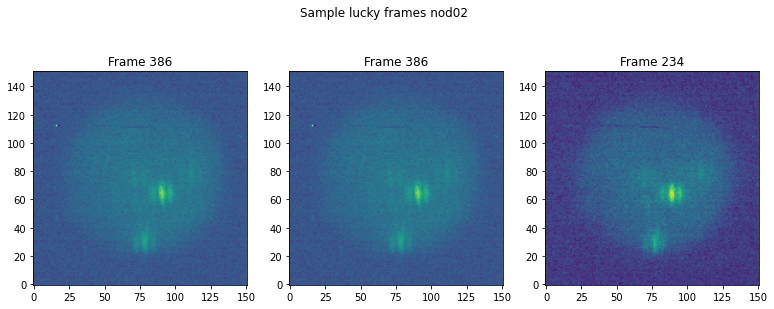

8


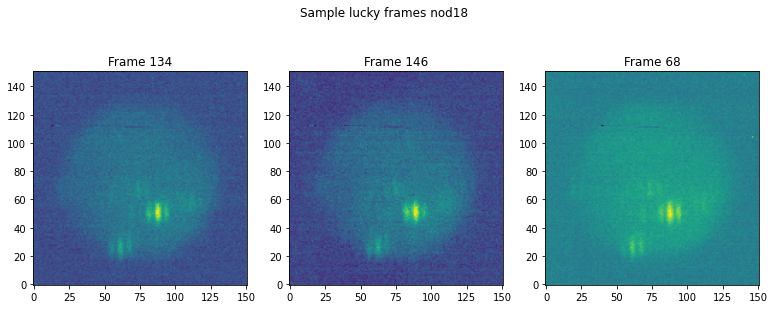

(22, 151, 151) (22, 151, 151)
2022-11-07 05:27:23


In [234]:
# PSF fittable model object from make-psf.ipynb
with open(paths.data / 'psf_fittable_model.pkl', 'rb') as f:
    epsf = pickle.load(f)
print(type(epsf))

# load the data cube
io_hdul = fits.open(paths.data / 'lucky_nav.fits')
io_data = io_hdul[0].data
io_header = io_hdul[0].header

# load the raw frames
frameids = ['01', '02', '18']

frames = []
lucky_frames = []
lucky_times = []
lucky_angles = []
for fid in frameids:
    stem = f'nod{fid}'

    # fits file of data frames
    hdul = fits.open(paths.data / f'{stem}disk.fits')
    framesi = hdul[0].data
    hdr = hdul[0].header
    frames.append(framesi)

    # text file of lucky frames
    lucky_ids = np.loadtxt(paths.data / f'{stem}log.txt', delimiter = ',').T[0].astype(int) - 1
    l_frames = framesi[lucky_ids]
    lucky_frames.append(l_frames)

    # plot some sample lucky frames
    fig, axes = plt.subplots(1,3, figsize = (13, 5))
    for ax in axes:
        i = np.random.choice(lucky_ids.size)
        ax.imshow(l_frames[i], origin='lower')
        ax.set_title(f'Frame {lucky_ids[i]}')
    fig.suptitle(f'Sample lucky frames {stem}')
    plt.show()

    # text file of frame times
    frame_hours = []
    with open(paths.data / f'{stem}utc.txt', 'r') as f:
        for l in f:
            seconds_utc = float(l[45:53])*3600
            time_utc = timedelta(seconds = seconds_utc)
            frame_hours.append(time_utc)
    obsdate = datetime.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    frame_times = np.array([obsdate + delta for delta in frame_hours])
    lucky_times.append(frame_times[lucky_ids])

    # text file of parallactic angles
    parallaxes = []
    with open(paths.data / f'{stem}para.txt', 'r') as f:
        for l in f:
            parallaxes.append(float(l[45:53]))
    rotation_angles = np.array(parallaxes) #ccw
    lucky_angles.append(rotation_angles[lucky_ids])
    

frames = np.concatenate(frames)
lucky_frames = np.concatenate(lucky_frames)
lucky_times = np.concatenate(lucky_times)
lucky_angles = np.concatenate(lucky_angles)

# hack to make this all operate on the raw frames
print(io_data.shape, lucky_frames.shape)
io_data = lucky_frames

obstime = datetime.strptime(io_header['DATE-OBS']+io_header['TIME-OBS'][:-3], '%Y-%m-%d%H:%M:%S')
print(obstime)

## make a flat disk model convolved with beam

No limb-darkening for now

False
True
(151, 151) (151, 151)


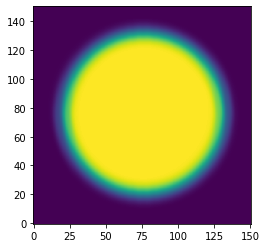

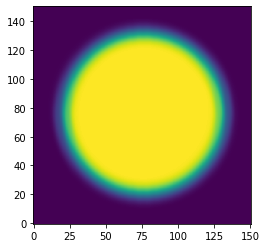

In [246]:
# determine radius of Io in pixels
io_r_km = 1821
pixscale_arcsec = 0.01071 #arcsec, lbti
    
# call Horizons for the appropriate datetime
end_time = obstime + timedelta(minutes=1)
epochs = {'start':obstime.strftime('%Y-%m-%d %H:%M:%S'), 
          'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 
          'step':'1m'}
# convert pixscale from arcsec to km
obj = Horizons(id='501', location='G83', epochs=epochs) #Io, Mt Graham
ephem = obj.ephemerides()
d_AU = ephem['delta'][0]*u.au
dist = d_AU.to(u.km).value
pixscale_km = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))

io_r_px = io_r_km / pixscale_km

# make a FittableModel object from the disk
disk_model = Disk2D(amplitude=15, x_0=0, y_0=0, R_0=io_r_px, fixed={'R_0':True})
disk_conv = convolve_models(disk_model, epsf)
#print(disk_conv)

# try turning this model into a FittableImageModel
sz = data.shape[0]/2
xx, yy = np.meshgrid(np.arange(-sz,sz), np.arange(-sz, sz))
print(xx.shape, data.shape)
disk_image = disk_conv(xx, yy)
plt.imshow(disk_image, origin='lower')
plt.show()

# new x,y grid here to hopefully agree with output from star finder
xx, yy = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
disk_model = FittableImageModel(disk_image, normalize=False, origin = (0,0))
disk_model.flux = 15
disk_model.flux.min = 0.0
plt.imshow(disk_model(xx, yy), origin='lower')

## add to this a model of all the point sources in the image

Need to deconstruct the steps of BasicPSFPhotometry and get FittableModel instances for each volcano in the image

(22, 151, 151)
Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <FittableImageModel(flux=15., x_0=0., y_0=0.)>

    [1]: <EPSFModel(flux=8775.06763163, x_0=79.44215514, y_0=30.43028305)>

    [2]: <EPSFModel(flux=8632.41218903, x_0=65.57860245, y_0=35.13361228)>

    [3]: <EPSFModel(flux=16732.83040118, x_0=89.961663, y_0=61.13643464)>

    [4]: <EPSFModel(flux=11548.39094607, x_0=70.55404428, y_0=73.58553274)>

    [5]: <EPSFModel(flux=10966.83305176, x_0=110.58735524, y_0=76.46398794)>
Parameters:
    flux_0 x_0_0 y_0_0 ...       flux_5            x_0_5              y_0_5      
    ------ ----- ----- ... ----------------- ------------------ -----------------
      15.0   0.0   0.0 ... 10966.83305175873 110.58735523560962 76.46398793889823


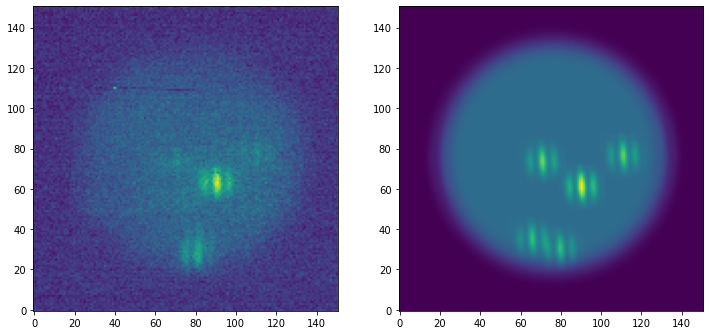

In [216]:
print(io_data.shape)
data = io_data[0]

# find all the point sources by basic align and take mean
aligned_data = chisq_stack(io_data, showplot = True, edge_detect=False)
data_mean = np.mean(aligned_data, axis=0)
thresh = 0.9*np.std(data_mean)
star_finder = StarFinder(thresh, epsf.data) #threshold, kernel
sources = star_finder(data_mean)
#print(sources)

combined_model = disk_model
for i, src in enumerate(sources):
    star = copy.deepcopy(epsf)
    star.x_0 = src['xcentroid']
    star.y_0 = src['ycentroid']
    star.flux = src['flux']
    star.flux.min = 0.0
    combined_model += star
print(combined_model)

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (12,6))
ax0.imshow(data, origin = 'lower')
ax1.imshow(combined_model(xx, yy), origin = 'lower')
plt.show()

## Fit the model to the data

In [243]:
fitter = LMLSQFitter(calc_uncertainties=False)
y, x = np.mgrid[:data.shape[0], :data.shape[1]]
output_model = fitter(combined_model, x, y, data, maxiter=2000)

(151, 151) (151, 151) (151, 151)


Model: CompoundModel
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <FittableImageModel(flux=0.91120596, x_0=2.55059572, y_0=-3.41605673)>

    [1]: <EPSFModel(flux=1321.38961315, x_0=81.18712856, y_0=29.3617016)>

    [2]: <EPSFModel(flux=0., x_0=65.58588891, y_0=35.23366396)>

    [3]: <EPSFModel(flux=2767.24215514, x_0=90.59529828, y_0=63.16341105)>

    [4]: <EPSFModel(flux=773.24906633, x_0=70.92738469, y_0=72.40954605)>

    [5]: <EPSFModel(flux=778.14566232, x_0=110.35600397, y_0=76.5925075)>
Parameters:
          flux_0             x_0_0       ...       x_0_5              y_0_5      
    ------------------ ----------------- ... ------------------ -----------------
    0.9112059629863775 2.550595724719894 ... 110.35600397075935 76.59250750352955
2.550595724719894


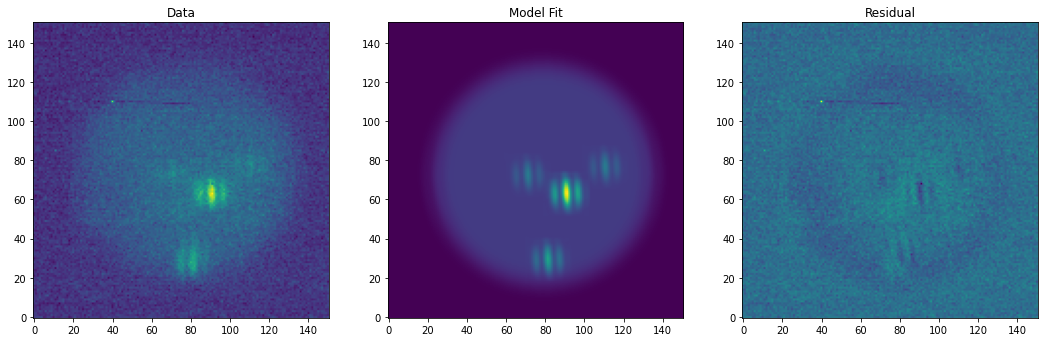

In [241]:
print(output_model)
print(output_model[0].x_0.value)

emakong_idx = np.argmax([m.flux.value for m in output_model])

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18, 6))
ax0.imshow(data, origin = 'lower')
ax0.set_title('Data')

ax1.imshow(output_model(xx, yy), origin = 'lower')
ax1.set_title('Model Fit')

ax2.imshow(data - output_model(xx, yy), origin='lower')
ax2.set_title('Residual')

plt.show()

starting frame 0


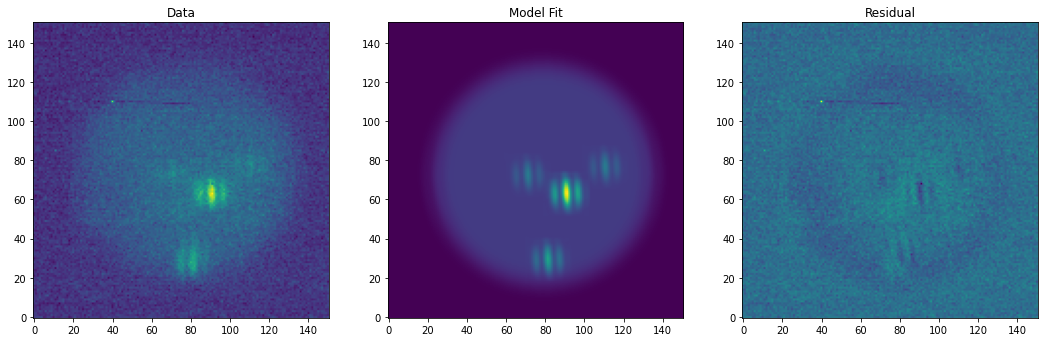

starting frame 1
starting frame 2
starting frame 3
starting frame 4
starting frame 5


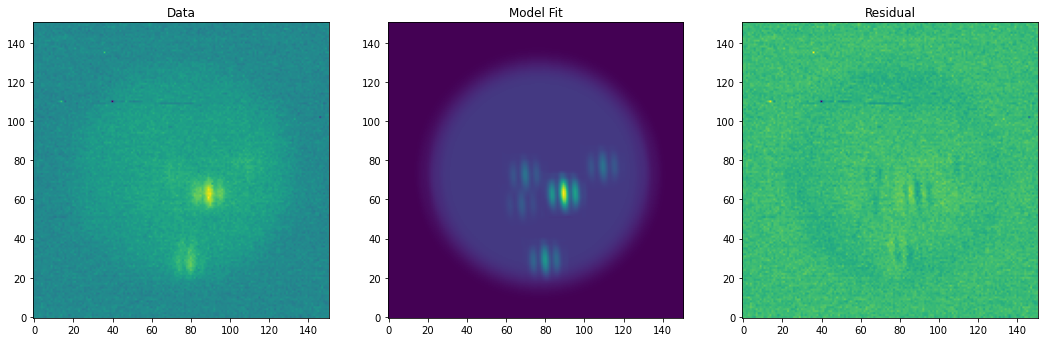

starting frame 6
starting frame 7
starting frame 8
starting frame 9
starting frame 10


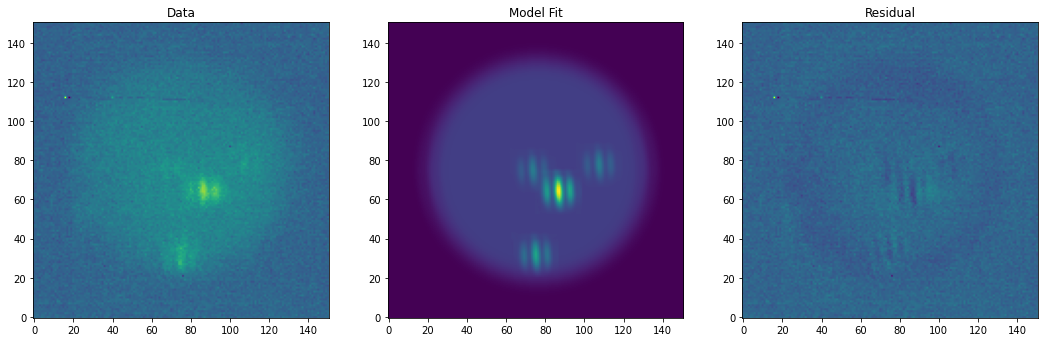

starting frame 11
starting frame 12
starting frame 13
starting frame 14
starting frame 15


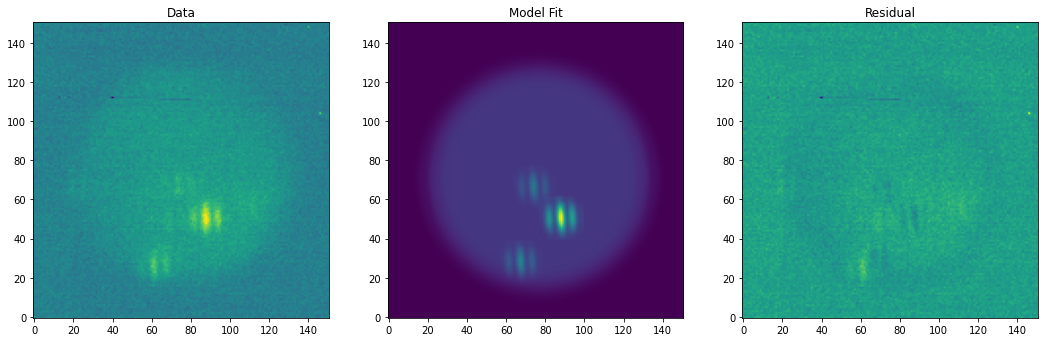

starting frame 16
starting frame 17
starting frame 18
starting frame 19
starting frame 20


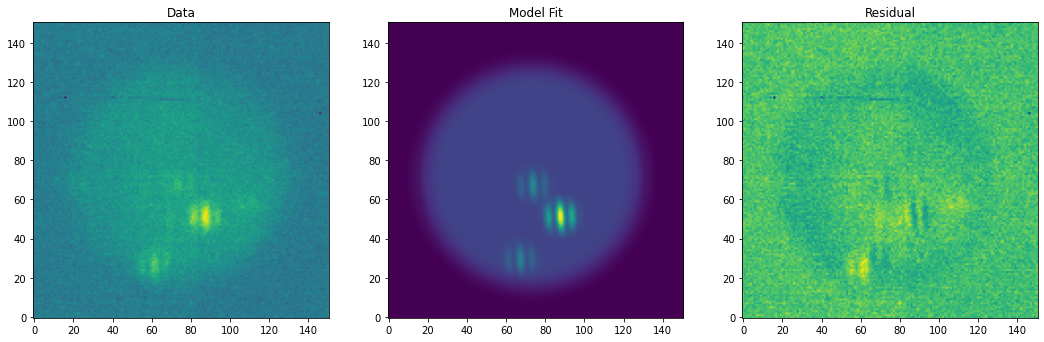

starting frame 21


In [219]:
## repeat for all the frames
x0, y0 = [], []
xe, ye = [], []
emakong_flux = []
disk_flux = []
for i in range(io_data.shape[0]):
    print(f'starting frame {i}')
    
    # find volcanoes
    combined_model = copy.deepcopy(disk_model)
    for j, src in enumerate(sources):
        star = copy.deepcopy(epsf)
        star.x_0 = src['xcentroid']
        star.y_0 = src['ycentroid']
        star.flux = src['flux']
        star.flux.min = 0.0
        combined_model += star
    
    output_model = fitter(combined_model, x, y, io_data[i], maxiter=2000)
    x0.append(output_model[0].x_0.value)
    y0.append(output_model[0].y_0.value)
    
    # find Emakong as the brightest source
    emakong_idx = np.argmax([m.flux.value for m in output_model])
    xe.append(output_model[emakong_idx].x_0.value)
    ye.append(output_model[emakong_idx].y_0.value)
    emakong_flux.append(output_model[emakong_idx].flux.value)
    disk_flux.append(output_model[0].flux.value)
    
    # make representative plots for a few of them
    if i%5 == 0:
        fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18, 6))
        ax0.imshow(io_data[i], origin = 'lower')
        ax0.set_title('Data')
        ax1.imshow(output_model(xx, yy), origin = 'lower')
        ax1.set_title('Model Fit')
        ax2.imshow(io_data[i] - output_model(xx, yy), origin='lower')
        ax2.set_title('Residual')
        plt.show()


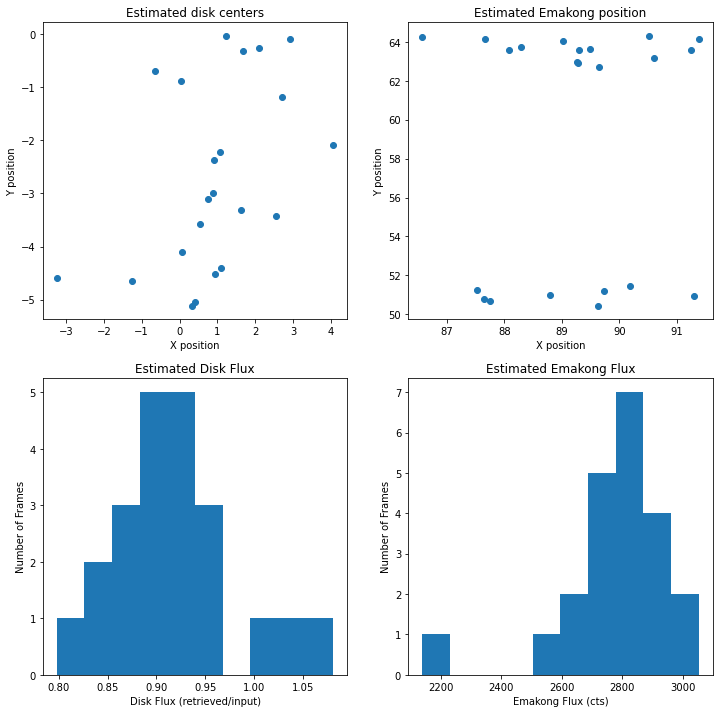

Disk X = 0.9441556149988607 +/- 1.495485863200805
Disk Y = -2.678686211772779 +/- 1.7124291481324756


In [229]:
x0 = np.array(x0)
y0 = np.array(y0)
xe = np.array(xe)
ye = np.array(ye)

fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2,2, figsize=(12,12)) 

ax0.scatter(x0, y0)
ax0.set_xlabel('X position')
ax0.set_ylabel('Y position')
ax0.set_title('Estimated disk centers')

ax1.scatter(xe, ye)
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.set_title('Estimated Emakong position')

ax2.hist(disk_flux)
ax2.set_xlabel('Disk Flux (retrieved/input)')
ax2.set_ylabel('Number of Frames')
ax2.set_title('Estimated Disk Flux')
      
ax3.hist(emakong_flux)
ax3.set_xlabel('Emakong Flux (cts)')
ax3.set_ylabel('Number of Frames')
ax3.set_title('Estimated Emakong Flux')

plt.show()

print(f'Disk X = {np.mean(x0)} +/- {np.std(x0)}')
print(f'Disk Y = {np.mean(y0)} +/- {np.std(y0)}')

group 0
x, y variance in disk location 1.2019755908696665 0.5524727521185376
x, y variance in difference 0.7103668994943305 0.2844960271919229
group 1
x, y variance in disk location 1.2347823459555742 0.3987509498118508
x, y variance in difference 0.8946342130514562 0.4941906865567
group 2
x, y variance in disk location 1.417375801078363 0.3269073897593063
x, y variance in difference 1.7705083865705749 0.2788264189581861


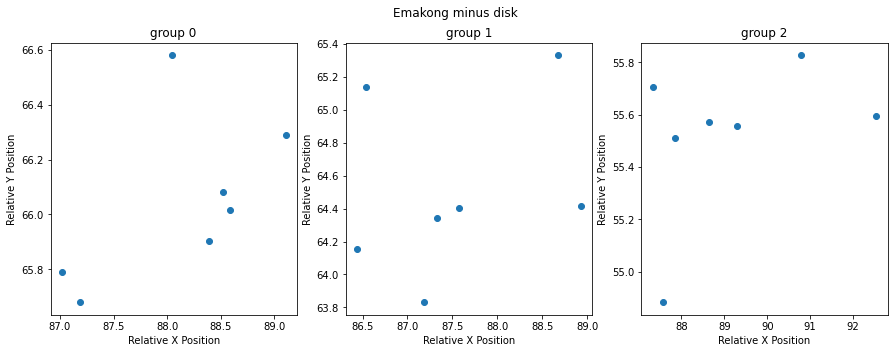

In [236]:
# test whether Emakong minus disk has lower variance than just Emakong
# this needs to be done group-by-group

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15,5))

for i, ax in enumerate([ax0, ax1, ax2]):
    
    print(f"group {i}")
    print('x, y variance in disk location', np.std(x0[7*i:7*i+7]), np.std(y0[7*i:7*i+7]))
    dx = xe[7*i:7*i+7] - x0[7*i:7*i+7]
    dy = ye[7*i:7*i+7] - y0[7*i:7*i+7]
    print('x, y variance in difference', np.std(dx), np.std(dy))
    ax.scatter(dx, dy)
    ax.set_xlabel('Relative X Position')
    ax.set_ylabel('Relative Y Position')
    ax.set_title(f"group {i}")
    
fig.suptitle('Emakong minus disk')
plt.show()

In [224]:
# save the data for comparison with navigate-frames.ipynb
d_out = np.asarray([x0, y0])
np.save('diagnostic_data/xy_fluxmodel.npy', d_out)

## Possible Improvements

- start with limb-darkened disk. Since using FittableImageModel, will need to manually play with ldparam

## Super-resolution lat-lon grids

- Make lat/lon grids at 10x resolution
- shift them to the retrieved x,y positions from above
- extract Emakong lat/lon based on the retrieved x,y position above

In [ ]:
from pylanetary.planetnav import *
from scipy.ndimage import zoom
pixscale_arcsec = 0.01071 #arcsec, lbti
req = 1821 #km
rpol = req #circular
z = 11

rmsvals = []
emakong_lat = []
emakong_lon = []
for i, obstime in enumerate(lucky_times):
    
    print(f'starting frame {i}')
    frame = io_data[i]
    angle = lucky_angles[i]
    
    # call Horizons for the appropriate datetime
    end_time = obstime + timedelta(minutes=1)
    epochs = {'start':obstime.strftime('%Y-%m-%d %H:%M:%S'), 
              'stop':end_time.strftime('%Y-%m-%d %H:%M:%S'), 
              'step':'1m'}
    # convert pixscale from arcsec to km
    obj = Horizons(id='501', location='G83', epochs=epochs) #Io, Mt Graham
    ephem = obj.ephemerides()
    d_AU = ephem['delta'][0]*u.au
    dist = d_AU.to(u.km).value
    pixscale_km = dist*np.tan(np.deg2rad(pixscale_arcsec/3600.))
    
    # adjust north pole angle according to parallactic angle
    npang = ephem[0]['NPole_ang']
    #ephem[0]['NPole_ang'] = (npang + angle)%360
    ephem[0]['NPole_ang'] = (npang - angle)%360
    
    # make a planetnav object
    frame_z = zoom(frame, z)
    nav = Nav(frame_z, ephem[0], req, rpol, pixscale_arcsec/z)
    
    # find per-frame rms noise
    n = 20
    err_region = np.concatenate([frame[:n, :n].flatten(),
                           frame[-n:, :n].flatten(),
                           frame[:n, -n:].flatten(),
                           frame[-n:, -n:].flatten(),])
    rms_noise = np.std(err_region)
    rmsvals.append(rms_noise)
    
    # convert the Emakong position and disk center position to super-resolution grid
    dx, dy = x0[i]*z, y0[i]*z
    dxe, dye = xe[i]*z, ye[i]*z
    nav.xy_shift_data(-dx, -dy)
    
    # extract lat-lon of Emakong
    emakong_lat.append(nav.lat_g[int(dye), int(dxe)])
    emakong_lon.append(nav.lon_w[int(dye), int(dxe)])
    
    # sanity check plot
    if i%10 == 0:
        circ = np.ones(nav.lon_w.shape)
        circ[np.isnan(nav.lon_w)] = -999
        plt.imshow(nav.data, origin='lower', cmap='Greys_r')
        plt.contour(circ, levels = [0], colors='red')
        plt.contour(nav.lat_g, levels = np.linspace(-90, 90, 7), colors='red')
        plt.title(f'Frame {i} ({z}x supersample)')
        plt.show()

[[128.43960751 129.08190051 128.06158791 131.13823119 129.80308862
  129.72416887 129.63666913 129.29577202 132.04106085 131.4133165
  133.74575932 132.81720322 130.91237685 130.30797646 128.23904675
  129.23017003 128.90555416 126.94752215 127.82327602 129.41970416
  129.89634938 128.11815311]
 [ -1.85204318  -2.69122324  -1.13429598  -2.58063531  -1.81812697
   -2.57712504  -2.53218006   0.61319306  -1.23974666  -0.72488782
   -1.81579454  -1.26282141  -0.98572924   0.35730683  -2.21161542
   -4.11282404  -3.02468297  -1.09926732  -2.71544296  -4.07721944
   -4.00991562  -1.72428019]]
<class 'numpy.ndarray'>


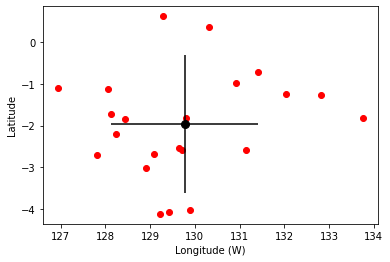

Emakong loc = (-1.964516249841572 +/- 1.2379636784972115 N, 129.77265885084444 +/- 1.6491114430696348 W)


In [223]:
# save the data for comparison with navigate-frames.ipynb
d_out = np.asarray([emakong_lon, emakong_lat])
np.save('diagnostic_data/latlon_fluxmodel.npy', d_out)


# plot
plt.scatter(emakong_lon, emakong_lat, color='red')
plt.errorbar(np.mean(emakong_lon), np.mean(emakong_lat), 
             xerr=np.std(emakong_lon), yerr=np.std(emakong_lon), 
             color = 'k', marker = 'o', markersize= 8)
plt.xlabel('Longitude (W)')
plt.ylabel('Latitude')
plt.show()

print(f'Emakong loc = ({np.mean(emakong_lat)} +/- {np.std(emakong_lat)} N, {np.mean(emakong_lon)} +/- {np.std(emakong_lon)} W)')

## To try

- add limb-darkening as if Lambertian reflection
- compare disk center locations between this notebook and navigate\_frames.ipynb
    - do they agree?
    - off-by-one errors?
- check accuracy of tip-tilt mirror somehow - talk to instrument team
- use expected rotation of Io and Earth to check expected vs observed path of Emakong across disk
    - this is hard and might not yield much new info
- some kind of completely new disk centering algorithm? but what?